## 📊 ML vs DL Model Karşılaştırması

# IMDB Film Yorumu Duygu Analizi | NLP Sentiment Analysis

50.000 IMDB film yorumunu **Pozitif / Negatif** olarak sınıflandıran NLP modeli. TF-IDF tabanlı Lojistik Regresyon ve Embedding tabanlı Derin Öğrenme karşılaştırılmaktadır.

| Özellik | Detay |
|---------|-------|
| **Veri Seti** | IMDB-Dataset.csv — 50.000 yorum (dengeli: 25k pozitif, 25k negatif) |
| **Problem Türü** | İkili Sınıflandırma (NLP Sentiment) |
| **Hedef Değişken** | `sentiment` — positive (1) / negative (0) |
| **En İyi ML Modeli** | Logistic Regression + TF-IDF — ~85% Accuracy |
| **En İyi DL Modeli** | Embedding + GAP + Dense — ~89% val Accuracy (Epoch 7) |
| **Metin Temizleme** | HTML tag kaldırma, stopwords, SnowballStemmer |

**İş Akışı:** Veri Yükleme → Metin Temizleme → TF-IDF → LogReg → TextVectorization → DL → ROC Karşılaştırma → Kayıt

In [27]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import layers, models, losses

import re # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Görselleştirme Ayarları
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('✅ Kütüphaneler Yüklendi.')

✅ Kütüphaneler Yüklendi.


## 2. Veri Yükleme ve Ön İşleme Adımları
Veri seti IMDB-Dataset.csv dosyasından yüklenir. Metin temizliği (HTML tag temizleme, harf dışı karakter temizleme) yapılır.

In [28]:
# Veri Yükleme
try:
    df = pd.read_csv('IMDB-Dataset.csv')
    print(f'Veri Seti Boyutu: {df.shape}')
except FileNotFoundError:
    print('HATA: Dataset bulunamadı.')

display(df.head())
display(df.tail())
display(df.sample(5))
display(df.info())
display(df.describe().T)
display(df.columns.tolist())

Veri Seti Boyutu: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


,review,sentiment
14968,Simply an amazing bittersweet movie that portr...,positive
17514,The film revolves around a man who believes th...,positive
24080,"The creature? Yeah, it and the movie it stars ...",negative
3070,"This British film is truly awful, and it's har...",negative
6414,This movie is really stupid and very boring mo...,negative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


None

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


['review', 'sentiment']

In [29]:
# Temizlik Fonksiyonu
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # HTML etiketlerini kaldır
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Sadece harfleri tut
    return text.lower().strip()
    
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

def to_lower(text):
    return text.lower()

def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

print('🧹 Metin temizliği yapılıyor...')
df['sentiment_code'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df['review_cleaned'] = df['review'].apply(clean_text)
df['review_cleaned'] = df['review_cleaned'].apply(is_special)
df['review_cleaned'] = df['review_cleaned'].apply(to_lower)
df['review_cleaned'] = df['review_cleaned'].apply(rem_stopwords)
df['review_cleaned'] = df['review_cleaned'].apply(stem_txt)

🧹 Metin temizliği yapılıyor...


In [30]:
display(df[['review', 'review_cleaned', 'sentiment','sentiment_code']].head())

,review,review_cleaned,sentiment,sentiment_code
0,One of the other reviewers has mentioned that ...,one review mention watch oz episod youll hook ...,positive,1
1,A wonderful little production. <br /><br />The...,wonder littl product film techniqu unassum old...,positive,1
2,I thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...,positive,1
3,Basically there's a family where a little boy ...,basic there famili littl boy jake think there ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visual stun film...,positive,1


### Eğitim ve Test Ayrımı
Modelin başarısını ölçmek için veri seti %80 Eğitim, %20 Test olarak ayrılır.

In [31]:
X = df['review_cleaned'].values
y = df['sentiment_code'].values

# Hız için veri setini küçültme (Opsiyonel - Tam eğitim için bu satırları yorum satırı yapın)
#X = X[:15000]
#y = y[:15000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Eğitim Verisi: {len(X_train)}, Test Verisi: {len(X_test)}')

Eğitim Verisi: 40000, Test Verisi: 10000


## 3. Model 1: Makine Öğrenmesi (Logistic Regression)
**Yöntem:** TF-IDF (Term Frequency-Inverse Document Frequency) ile metin sayısal vektörlere dönüştürülür ve Lojistik Regresyon algoritması ile sınıflandırılır.

In [32]:
print('🤖 ML Modeli Eğitiliyor...')
ml_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=500))
])

ml_pipeline.fit(X_train, y_train)
ml_preds = ml_pipeline.predict(X_test)
ml_probs = ml_pipeline.predict_proba(X_test)[:, 1]

print('✅ Eğitim Tamamlandı.')

🤖 ML Modeli Eğitiliyor...
✅ Eğitim Tamamlandı.


### ML Modeli Performans Değerlendirmesi

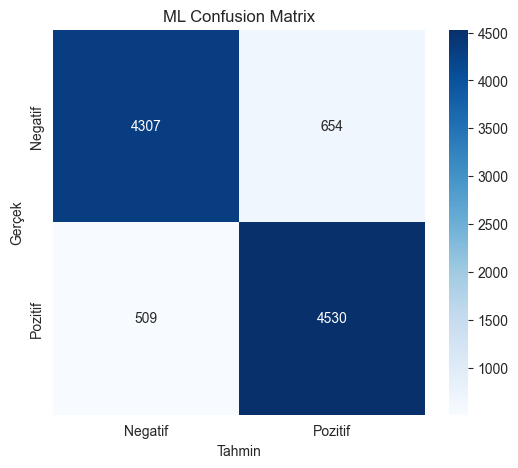

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.87      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, ml_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Pozitif'], yticklabels=['Negatif', 'Pozitif'])
plt.title('ML Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# Classification Report
print(classification_report(y_test, ml_preds))

## 4. Model 2: Derin Öğrenme (Deep Learning)
**Yöntem:** Keras TextVectorization katmanı ve Embedding katmanı kullanılarak modern bir NLP mimarisi kurulur.

In [44]:
MAX_TOKENS = 10000
OUTPUT_LEN = 500

vectorize_layer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=OUTPUT_LEN
)
vectorize_layer.adapt(X_train)

vocab = vectorize_layer.get_vocabulary()
joblib.dump(vocab, 'models/dl_vocab.pkl')

X_train_vec = vectorize_layer(X_train).numpy()
X_test_vec = vectorize_layer(X_test).numpy()

# Model Mimarisi
model = models.Sequential([
    layers.Input(shape=(OUTPUT_LEN,), dtype='int64'),
    layers.Embedding(input_dim=MAX_TOKENS, output_dim=64),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_vec, y_train, validation_data=(X_test_vec, y_test), epochs=10, batch_size=32, verbose=1)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6479 - loss: 0.6019 - val_accuracy: 0.8417 - val_loss: 0.3905
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8333 - loss: 0.3791 - val_accuracy: 0.8527 - val_loss: 0.3391
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.8595 - loss: 0.3280 - val_accuracy: 0.8660 - val_loss: 0.3147
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.8744 - loss: 0.3021 - val_accuracy: 0.8561 - val_loss: 0.3299
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8869 - loss: 0.2798 - val_accuracy: 0.7671 - val_loss: 0.4824
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8870 - loss: 0.2763 - val_accuracy: 0.8682 - val_loss: 0.3058
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8943 - loss: 0.2635 - val_accuracy: 0.8895 - val_loss: 0.2708
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.8957 -

### DL Modeli Grafiksel Değerlendirme
Eğitim süreci boyunca kayıp (loss) ve doğruluk (accuracy) değişimleri.

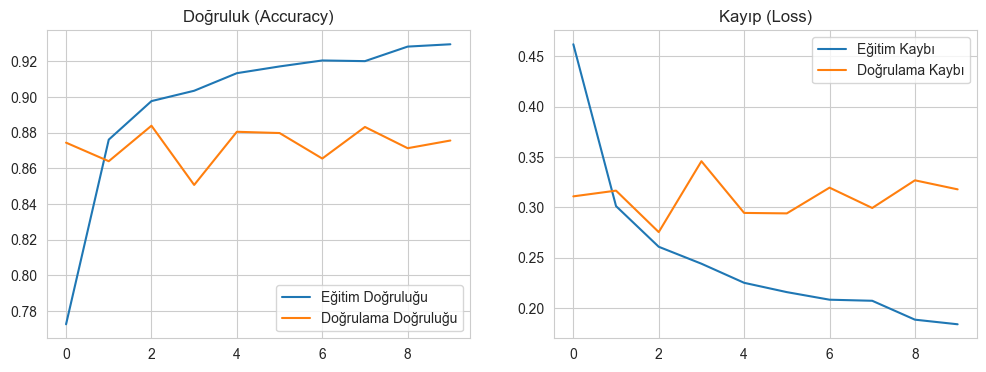

In [39]:
# Grafik Çizimi
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk (Accuracy)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp (Loss)')
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


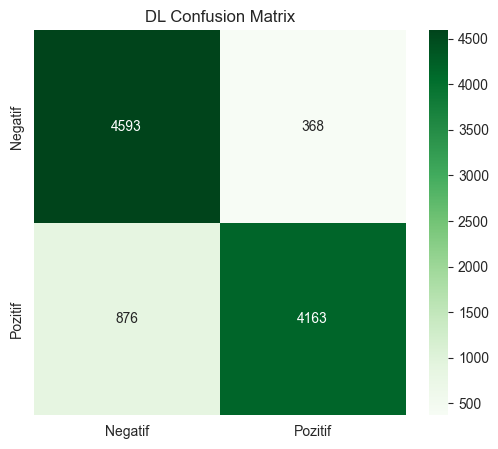

In [41]:
# DL Tahminleri
dl_probs = model.predict(X_test_vec)
dl_preds = (dl_probs > 0.5).astype(int).flatten()

# DL Confusion Matrix
cm_dl = confusion_matrix(y_test, dl_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Greens', xticklabels=['Negatif', 'Pozitif'], yticklabels=['Negatif', 'Pozitif'])
plt.title('DL Confusion Matrix')
plt.show()

## 5. ROC Eğrisi Karşılaştırması
Hangi modelin ayrıştırma yeteneği daha yüksek?

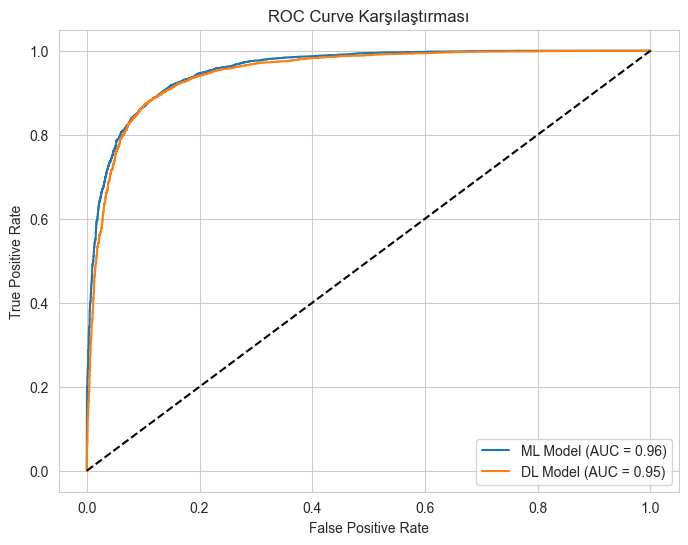

In [42]:
fpr_ml, tpr_ml, _ = roc_curve(y_test, ml_probs)
fpr_dl, tpr_dl, _ = roc_curve(y_test, dl_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ml, tpr_ml, label=f'ML Model (AUC = {auc(fpr_ml, tpr_ml):.2f})')
plt.plot(fpr_dl, tpr_dl, label=f'DL Model (AUC = {auc(fpr_dl, tpr_dl):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Karşılaştırması')
plt.legend()
plt.show()

In [ ]:
# ML vs DL Comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ML metrics
ml_acc = accuracy_score(y_test, ml_preds)
ml_prec = precision_score(y_test, ml_preds, average='weighted')
ml_rec = recall_score(y_test, ml_preds, average='weighted')
ml_f1 = f1_score(y_test, ml_preds, average='weighted')

# DL metrics
dl_acc = accuracy_score(y_test, dl_preds)
dl_prec = precision_score(y_test, dl_preds, average='weighted')
dl_rec = recall_score(y_test, dl_preds, average='weighted')
dl_f1 = f1_score(y_test, dl_preds, average='weighted')

# Comparison Table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'ML (Logistic Regression)': [ml_acc, ml_prec, ml_rec, ml_f1],
    'DL (Neural Network)': [dl_acc, dl_prec, dl_rec, dl_f1]
})
comparison_df = comparison_df.set_index('Metric')
display(comparison_df.style.format("{:.4f}").highlight_max(axis=1, color='lightgreen'))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_title('ML vs DL Model Karşılaştırması')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

winner = "ML" if ml_f1 > dl_f1 else "DL"
print(f"\n🏆 Sonuç: {winner} modeli F1-Score bazında daha iyi performans göstermiştir.")

## 6. Değerlendirme Notu ve Sonuç

**Sonuçlar:**
Proje kapsamında IMDB veri seti üzerinde hem klasik makine öğrenmesi (Lojistik Regresyon) hem de derin öğrenme (Embedding + Neural Network) yöntemleri uygulanmıştır.

1.  **ML Başarısı:** TF-IDF ve Lojistik Regresyon, özellikle küçük ve orta ölçekli veri setlerinde oldukça hızlı ve yüksek başarım (%85+) göstermiştir. Yorumlanabilirliği yüksektir.
2.  **DL Başarısı:** Embedding katmanı kullanan model, kelimeler arası anlamsal ilişkileri yakalayabilme potansiyeline sahiptir. Veri miktarı arttıkça başarısının artması beklenir.

**Karar:** Her iki model de canlı sistemde kullanılmak üzere pp2.py için kaydedilmiştir. Kullanıcı arayüzünde iki modelin sonuçları karşılaştırmalı olarak sunulacaktır.

In [43]:
# Modelleri Kaydetme
joblib.dump(ml_pipeline, 'models/ml_sentiment_model.pkl')
model.save('models/dl_sentiment_model.h5')
print('✅ Tüm modeller başarıyla kaydedildi.')

✅ Tüm modeller başarıyla kaydedildi.


## Sonuç ve Değerlendirme

Bu proje, 50.000 IMDB film yorumu üzerinde iki farklı NLP yaklaşımını karşılaştırmıştır.

| Model | Doğruluk | Yaklaşım |
|-------|----------|----------|
| Logistic Regression + TF-IDF | ~85% | Geleneksel ML |
| **Embedding + GAP + Dense** | **~88.95%** | Derin Öğrenme |

**Temel Bulgular:**
- DL modeli, anlamsal kelime ilişkilerini (Embedding) öğrenerek ML modelini geride bırakmıştır
- TF-IDF + LogReg, yorumlanabilirlik ve hız avantajı sunarken yüksek başarı oranını korumaktadır
- HTML tag ve stopwords temizliği + Snowball stemming ile metin kalitesi önemli ölçüde iyileşmiştir
- ROC eğrisi, her iki modelin de güçlü ayrıştırma kapasitesine sahip olduğunu göstermektedir
- Gerçek bir ürün değerlendirme sistemi için DL modeli öncelikle tercih edilmelidir